In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import warnings
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import geopandas as gpd
from adjustText import adjust_text
warnings.filterwarnings('ignore')

data = pd.read_csv('Q5yravg_HOF.csv')

p={'HOF': 'forestgreen', 'Non-HOF': 'darkkhaki'}

Random_Forest Model Validation Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       230
           1       0.95      0.98      0.97       232

    accuracy                           0.97       462
   macro avg       0.97      0.97      0.97       462
weighted avg       0.97      0.97      0.97       462



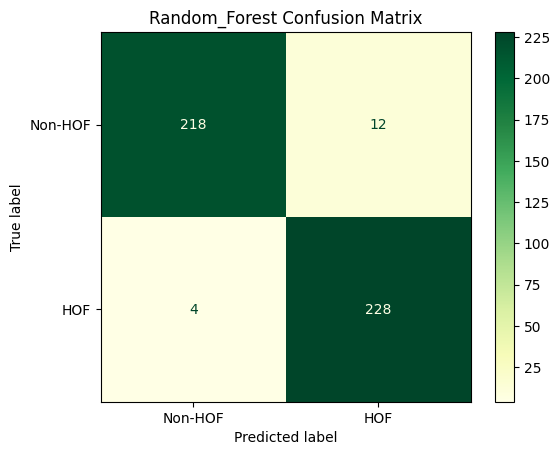

Logistic_Regression Model Validation Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       230
           1       0.77      0.80      0.78       232

    accuracy                           0.78       462
   macro avg       0.78      0.78      0.78       462
weighted avg       0.78      0.78      0.78       462



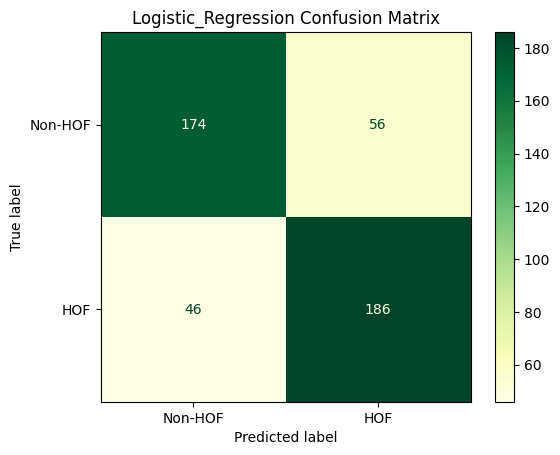

Decision_Tree Model Validation Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       230
           1       0.89      0.93      0.91       232

    accuracy                           0.90       462
   macro avg       0.91      0.90      0.90       462
weighted avg       0.91      0.90      0.90       462



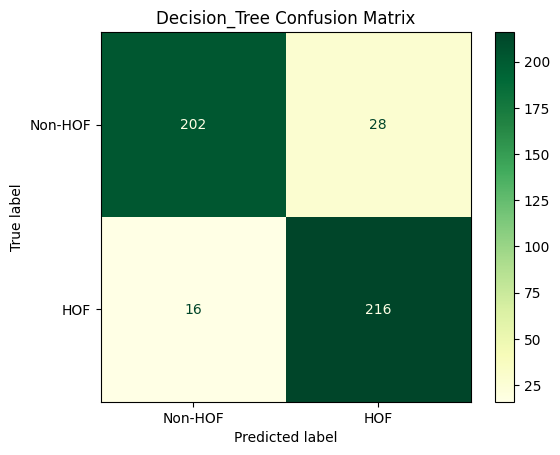

Gradient_Boosting Model Validation Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       230
           1       0.89      0.97      0.93       232

    accuracy                           0.93       462
   macro avg       0.93      0.93      0.93       462
weighted avg       0.93      0.93      0.93       462



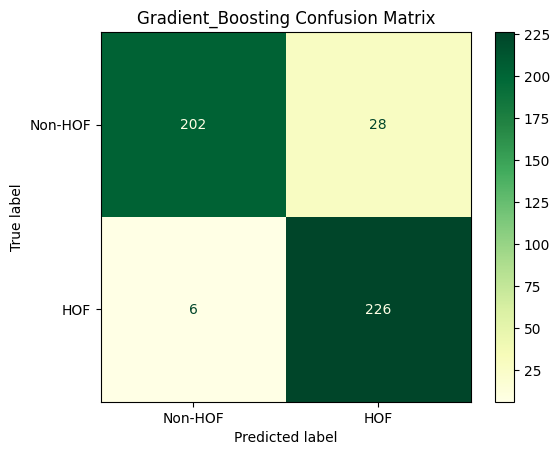

F1 Scores for Each Model:
Random_Forest: F1 Score = 0.9661
Logistic_Regression: F1 Score = 0.7848
Decision_Tree: F1 Score = 0.9076
Gradient_Boosting: F1 Score = 0.9300


In [2]:
data['id'] = data['id'].astype(str)

selected_columns = [
    'id', 'debutyear', 'finalyear', 'playername',
    'hits', 'homeruns', 'battingaverage', 'onbasepercent', 'slugging', 
    'doubles', 'triples', 'runsbattedin', 'runs', 
    'stolenbases', 'caughtstealing', 'strikeouts', 'walks', 'inducted'
]
drop_columns = ['id', 'debutyear', 'finalyear']
categorical_columns = []

def prepare_data(data, selected_columns, drop_columns, categorical_columns):
    data = data[selected_columns]
    
    train_val_data = data[data['finalyear'] <= 2018].copy()
    test_data = data[data['finalyear'] >= 2019].copy()
    
    train_val_data_ids = train_val_data[['id']]
    test_data_ids = test_data[['id']]
    
    train_val_data = train_val_data.drop(columns=drop_columns)
    test_data = test_data.drop(columns=drop_columns)
  
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    if len(categorical_columns) > 0:
        categorical_data_train_val = train_val_data[categorical_columns]
        numerical_data_train_val = train_val_data.drop(columns=categorical_columns)
        categorical_data_test = test_data[categorical_columns]
        numerical_data_test = test_data.drop(columns=categorical_columns)

        train_val_cat = encoder.fit_transform(categorical_data_train_val)
        test_cat = encoder.transform(categorical_data_test)
    
        train_val_cat_df = pd.DataFrame(train_val_cat, columns=encoder.get_feature_names_out(categorical_columns), index=train_val_data.index)
        test_cat_df = pd.DataFrame(test_cat, columns=encoder.get_feature_names_out(categorical_columns), index=test_data.index)
        
        train_val_data = pd.concat([numerical_data_train_val, train_val_cat_df], axis=1)
        test_data = pd.concat([numerical_data_test, test_cat_df], axis=1)
    
    train_val_data = pd.concat([train_val_data_ids, train_val_data], axis=1)
    test_data = pd.concat([test_data_ids, test_data], axis=1)
    
    return train_val_data, test_data

train_val_data, test_data = prepare_data(data, selected_columns, drop_columns, categorical_columns)

player_names = data[['id', 'playername']].drop_duplicates()

train_val_df = pd.merge(train_val_data, player_names, on='id', how='left')
test_df = pd.merge(test_data, player_names, on='id', how='left')

train_val_df = train_val_df.rename(columns={'playername_x': 'playername'})
train_val_df = train_val_df.drop(columns=['playername_y'], errors='ignore')

test_df = test_df.rename(columns={'playername_x': 'playername'})
test_df = test_df.drop(columns=['playername_y'], errors='ignore')

numeric_columns = train_val_df.select_dtypes(include=['number']).columns
imputer = SimpleImputer(strategy='mean')
X_train_val = imputer.fit_transform(train_val_df[numeric_columns])
X_test = imputer.transform(test_df[numeric_columns])

y_train_val = train_val_df['inducted'].apply(lambda x: 1 if x == 'HOF' else 0)

smote = SMOTE(random_state=42)
X_train_val_balanced, y_train_val_balanced = smote.fit_resample(X_train_val, y_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_balanced, y_train_val_balanced, test_size=0.2, random_state=42)

models = {
    'Random_Forest': RandomForestClassifier(random_state=42),
    'Logistic_Regression': LogisticRegression(random_state=42, max_iter=10000),
    'Decision_Tree': DecisionTreeClassifier(random_state=42),
    'Gradient_Boosting': GradientBoostingClassifier(random_state=42)
}

results = pd.DataFrame({'id': test_df['id']})
f1_scores = {}

confusion_matrix_results = pd.DataFrame({'id': train_val_df['id'], 'playername': train_val_df['playername']})

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred)
    f1_scores[model_name] = f1
    
    print(f'{model_name} Model Validation Report:')
    print(classification_report(y_val, y_val_pred))
    
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-HOF', 'HOF'])
    disp.plot(cmap=plt.cm.YlGn)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    y_test_prob = model.predict_proba(X_test)[:, 1]
    results[f'HOF_prob_{model_name}'] = y_test_prob

    confusion_matrix_results[f'{model_name}_TP'] = (y_val_pred == 1) & (y_val == 1)
    confusion_matrix_results[f'{model_name}_TN'] = (y_val_pred == 0) & (y_val == 0)
    confusion_matrix_results[f'{model_name}_FP'] = (y_val_pred == 1) & (y_val == 0)
    confusion_matrix_results[f'{model_name}_FN'] = (y_val_pred == 0) & (y_val == 1)

for model_name in models.keys():
    results[f'prediction_{model_name.lower()}'] = results[f'HOF_prob_{model_name}'].apply(lambda x: 'HOF' if x > 0.5 else 'Non-HOF')

print("F1 Scores for Each Model:")
for model_name, f1 in f1_scores.items():
    print(f"{model_name}: F1 Score = {f1:.4f}")

merged_test_df = pd.merge(test_df, results, on='id', how='left')

val_df = pd.merge(train_val_df, confusion_matrix_results, on=['id', 'playername'], how='left')

In [3]:
val_df_cleaned = val_df.dropna(subset=['Decision_Tree_TP'])

In [4]:
gb_fp = val_df_cleaned[val_df_cleaned['Gradient_Boosting_FP'] == True]
gb_fn = val_df_cleaned[val_df_cleaned['Gradient_Boosting_FN'] == True]

In [5]:
merged_data = merged_test_df

In [6]:
prob_columns = {'rf': 'HOF_prob_Random_Forest', 'lr': 'HOF_prob_Logistic_Regression', 'dt': 'HOF_prob_Decision_Tree', 'gb': 'HOF_prob_Gradient_Boosting'}

for model_name, prob_col in prob_columns.items():
    merged_data[f'prediction_{model_name}'] = merged_data[prob_col].apply(lambda x: 'HOF' if x > 0.5 else 'Non-HOF')

In [7]:
rf_hof = merged_data[merged_data['prediction_rf'] == 'HOF']
rf_nonhof = merged_data[merged_data['prediction_rf'] == 'Non-HOF']
lr_hof = merged_data[merged_data['prediction_lr'] == 'HOF']
lr_nonhof = merged_data[merged_data['prediction_lr'] == 'Non-HOF']
dt_hof = merged_data[merged_data['prediction_dt'] == 'HOF']
dt_nonhof = merged_data[merged_data['prediction_dt'] == 'Non-HOF']
gb_hof = merged_data[merged_data['prediction_gb'] == 'HOF']
gb_nonhof = merged_data[merged_data['prediction_gb'] == 'Non-HOF']

In [8]:
df = merged_data
df_hof = gb_hof
df_nonhof = gb_nonhof

In [9]:
common_columns = set(df.columns).intersection(set(data.columns)) - {'id', 'playername'}

data_columns = [col for col in data.columns if col not in common_columns and col not in ['id', 'playername']]

merged_df = pd.merge(df, data[['id', 'playername'] + data_columns], on=['id', 'playername'], how='left')

In [10]:
rf_hof = merged_df[merged_df['prediction_rf'] == 'HOF']
rf_nonhof = merged_df[merged_df['prediction_rf'] == 'Non-HOF']
lr_hof = merged_df[merged_df['prediction_lr'] == 'HOF']
lr_nonhof = merged_df[merged_df['prediction_lr'] == 'Non-HOF']
dt_hof = merged_df[merged_df['prediction_dt'] == 'HOF']
dt_nonhof = merged_df[merged_df['prediction_dt'] == 'Non-HOF']
gb_hof = merged_df[merged_df['prediction_gb'] == 'HOF']
gb_nonhof = merged_df[merged_df['prediction_gb'] == 'Non-HOF']

In [11]:
df = merged_df
df_hof = gb_hof
df_nonhof = gb_nonhof

In [12]:
df.to_csv('Predictions.csv', index=False)

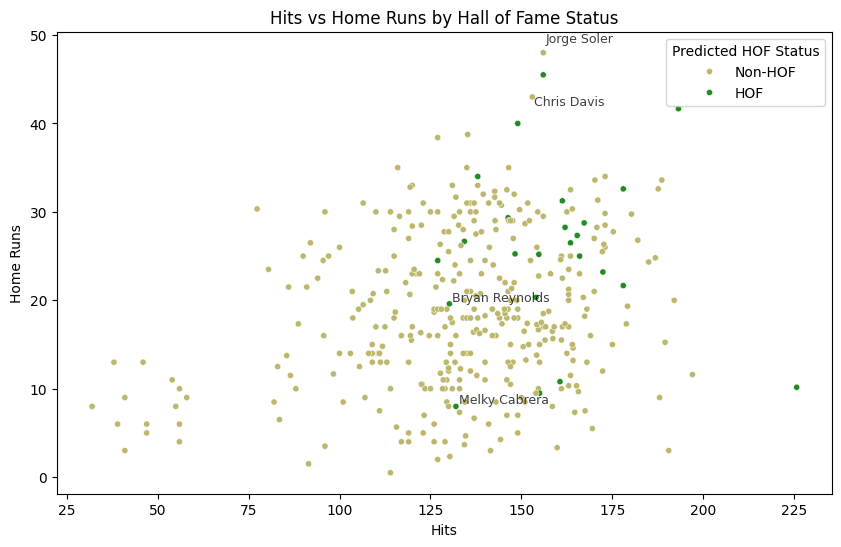

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hits', y='homeruns', hue='prediction_gb', data=df, palette={'HOF': 'forestgreen', 'Non-HOF': 'darkkhaki'}, s=20)
plt.title('Hits vs Home Runs by Hall of Fame Status')
plt.xlabel('Hits')
plt.ylabel('Home Runs')
plt.legend(title='Predicted HOF Status')

hof_outliers = df_hof[(df_hof['hits'] < 150) & (df_hof['homeruns'] < 20)]
nonhof_outliers = df_nonhof[(df_nonhof['hits'] > 200) | (df_nonhof['homeruns'] > 40)]

texts = []

for i in range(hof_outliers.shape[0]):
    texts.append(plt.text(hof_outliers['hits'].iloc[i], hof_outliers['homeruns'].iloc[i], hof_outliers['playername'].iloc[i], 
                          fontsize=9, alpha=0.75))

for i in range(nonhof_outliers.shape[0]):
    texts.append(plt.text(nonhof_outliers['hits'].iloc[i], nonhof_outliers['homeruns'].iloc[i], nonhof_outliers['playername'].iloc[i], 
                          fontsize=9, alpha=0.75))

adjust_text(texts)

plt.show()

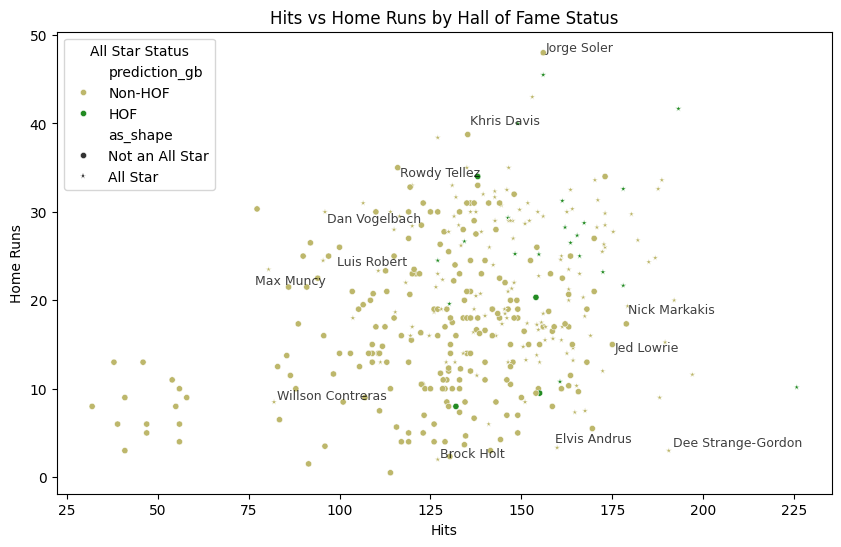

In [14]:
df['as_shape'] = df['as'].apply(lambda x: 'All Star' if x >= 1 else 'Not an All Star')

plt.figure(figsize=(10, 6))

sns.scatterplot(x='hits', y='homeruns', hue='prediction_gb', style='as_shape', 
                data=df, palette={'HOF': 'forestgreen', 'Non-HOF': 'darkkhaki'}, 
                markers={'All Star': '*', 'Not an All Star': 'o'}, s=20)

plt.title('Hits vs Home Runs by Hall of Fame Status')
plt.xlabel('Hits')
plt.ylabel('Home Runs')
plt.legend(title='All Star Status')

# Assuming you have DataFrames for HOF and Non-HOF outliers
as_outliers = df[df['as'] >= 1]
as_outliers = as_outliers[(as_outliers['hits'] <= 100) | (as_outliers['homeruns'] <= 5)]
nonas_outliers = df[df['as'] < 1]
nonas_outliers = nonas_outliers[(nonas_outliers['hits'] >= 175) | (nonas_outliers['homeruns'] >= 35)]

texts = []

for i in range(as_outliers.shape[0]):
    texts.append(plt.text(as_outliers['hits'].iloc[i], as_outliers['homeruns'].iloc[i], as_outliers['playername'].iloc[i], 
                          fontsize=9, alpha=0.75))

for i in range(nonas_outliers.shape[0]):
    texts.append(plt.text(nonas_outliers['hits'].iloc[i], nonas_outliers['homeruns'].iloc[i], nonas_outliers['playername'].iloc[i], 
                          fontsize=9, alpha=0.75))

adjust_text(texts)

plt.show()

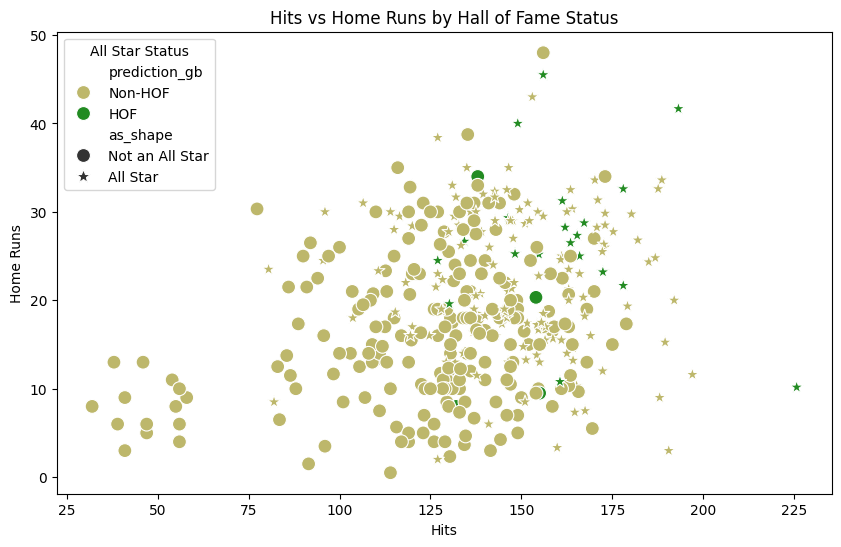

In [15]:
df['as_shape'] = df['as'].apply(lambda x: 'All Star' if x >= 1 else 'Not an All Star')

plt.figure(figsize=(10, 6))

sns.scatterplot(x='hits', y='homeruns', hue='prediction_gb', style='as_shape', 
                data=df, palette={'HOF': 'forestgreen', 'Non-HOF': 'darkkhaki'}, 
                markers={'All Star': '*', 'Not an All Star': 'o'}, s=100)
'''
# Print data ranges to ensure correct axis limits
print("Hits range:", df['hits'].min(), "to", df['hits'].max())
print("Home Runs range:", df['homeruns'].min(), "to", df['homeruns'].max())

# Set the x and y limits to ensure data points are visible
plt.xlim(df['hits'].min() - 10, df['hits'].max() + 10)
plt.ylim(df['homeruns'].min() - 5, df['homeruns'].max() + 5)
'''

plt.title('Hits vs Home Runs by Hall of Fame Status')
plt.xlabel('Hits')
plt.ylabel('Home Runs')
plt.legend(title='All Star Status')

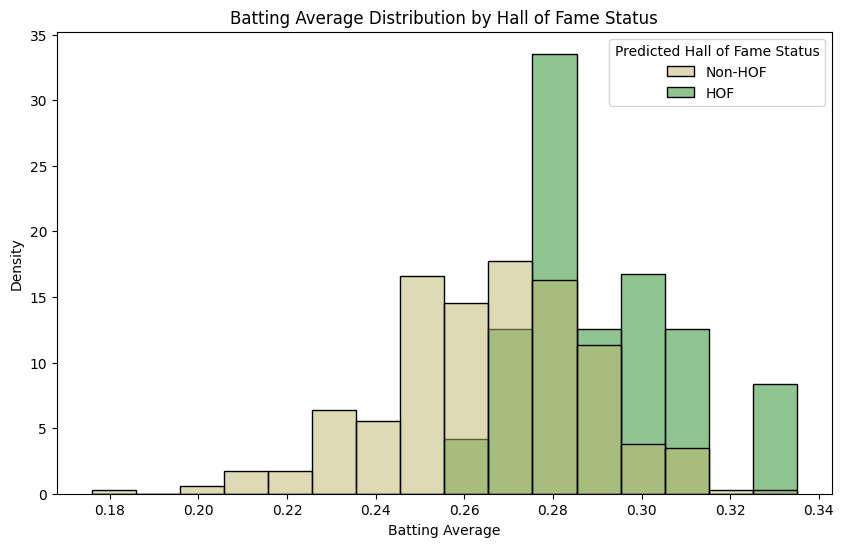

In [16]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='battingaverage', binwidth=0.01, hue='prediction_gb', palette={'HOF': 'forestgreen', 'Non-HOF': 'darkkhaki'}, alpha=0.5, kde=False, stat="density", common_norm=False)

legend = plt.gca().get_legend()

if legend:
    legend.set_title('Predicted Hall of Fame Status')
    for text in legend.get_texts():
        text.set_text(text.get_text())

plt.xlabel('Batting Average')
plt.ylabel('Density')
plt.title('Batting Average Distribution by Hall of Fame Status')

plt.show()

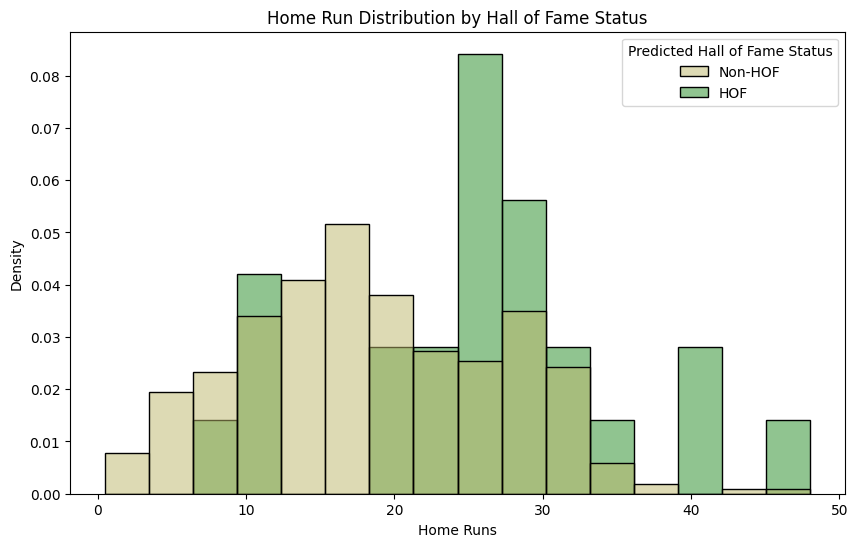

In [17]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='homeruns', binwidth=3, hue='prediction_gb', palette={'HOF': 'forestgreen', 'Non-HOF': 'darkkhaki'}, alpha=0.5, kde=False, stat="density", common_norm=False)

legend = plt.gca().get_legend()

if legend:
    legend.set_title('Predicted Hall of Fame Status')
    for text in legend.get_texts():
        text.set_text(text.get_text())

plt.xlabel('Home Runs')
plt.ylabel('Density')
plt.title('Home Run Distribution by Hall of Fame Status')

plt.show()

   hits_decile  total_players  hof_players  hof_percentage
0            0             37            0        0.000000
1            1             37            0        0.000000
2            2             37            0        0.000000
3            3             37            3        8.108108
4            4             37            1        2.702703
5            5             37            1        2.702703
6            6             37            3        8.108108
7            7             37            4       10.810811
8            8             37            7       18.918919
9            9             37            5       13.513514


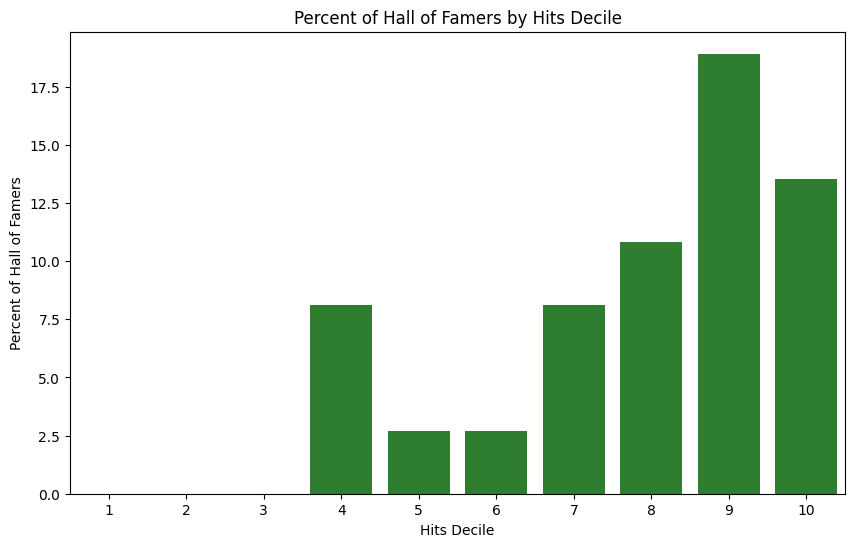

In [18]:
df['prediction_gb'] = df['prediction_gb'].replace({'HOF': 1, 'Non-HOF': 0})

df['hits'] = pd.to_numeric(df['hits'], errors='coerce')

np.random.seed(0)

df['hits_noisy'] = df['hits'] + np.random.normal(0, 1e-6, size=len(df))

num_deciles = 10

df['hits_decile'] = pd.qcut(df['hits_noisy'], q=num_deciles, labels=False)

decile_summary = df.groupby('hits_decile').agg(
    total_players=('playername', 'count'),
    hof_players=('prediction_gb', 'sum')
).reset_index()

decile_summary['hof_percentage'] = (decile_summary['hof_players'] / decile_summary['total_players']) * 100

print(decile_summary)

plt.figure(figsize=(10, 6))
sns.barplot(x='hits_decile', y='hof_percentage', data=decile_summary, color='forestgreen')
plt.xlabel('Hits Decile')
plt.ylabel('Percent of Hall of Famers')
plt.title('Percent of Hall of Famers by Hits Decile')
plt.xticks(ticks=range(num_deciles), labels=range(1, num_deciles + 1))
plt.show()

df['prediction_gb'] = df['prediction_gb'].replace({1: "HOF", 0: "Non-HOF"})

   hr_decile  total_players  hof_players  hof_percentage
0          0             37            0        0.000000
1          1             37            4       10.810811
2          2             37            0        0.000000
3          3             37            0        0.000000
4          4             37            0        0.000000
5          5             37            2        5.405405
6          6             37            2        5.405405
7          7             37            7       18.918919
8          8             37            3        8.108108
9          9             37            6       16.216216


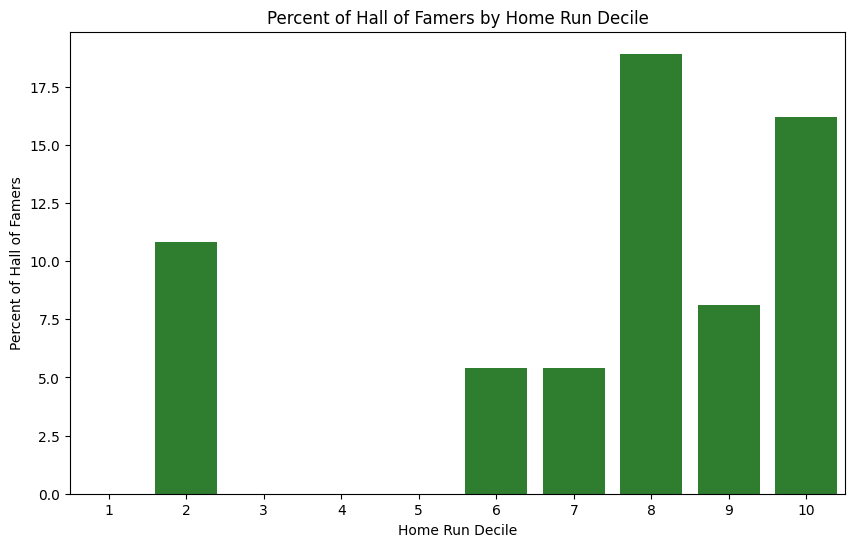

In [19]:
df['prediction_gb'] = df['prediction_gb'].replace({'HOF': 1, 'Non-HOF': 0})

df['homeruns'] = pd.to_numeric(df['homeruns'], errors='coerce')

np.random.seed(0)

df['homeruns_noisy'] = df['homeruns'] + np.random.normal(0, 1e-6, size=len(df))

num_deciles = 10

df['hr_decile'] = pd.qcut(df['homeruns_noisy'], q=num_deciles, labels=False)

decile_summary = df.groupby('hr_decile').agg(
    total_players=('playername', 'count'),
    hof_players=('prediction_gb', 'sum')
).reset_index()

decile_summary['hof_percentage'] = (decile_summary['hof_players'] / decile_summary['total_players']) * 100

print(decile_summary)

plt.figure(figsize=(10, 6))
sns.barplot(x='hr_decile', y='hof_percentage', data=decile_summary, color='forestgreen')
plt.xlabel('Home Run Decile')
plt.ylabel('Percent of Hall of Famers')
plt.title('Percent of Hall of Famers by Home Run Decile')
plt.xticks(ticks=range(num_deciles), labels=range(1, num_deciles + 1))
plt.show()

df['prediction_gb'] = df['prediction_gb'].replace({1: "HOF", 0: "Non-HOF"})

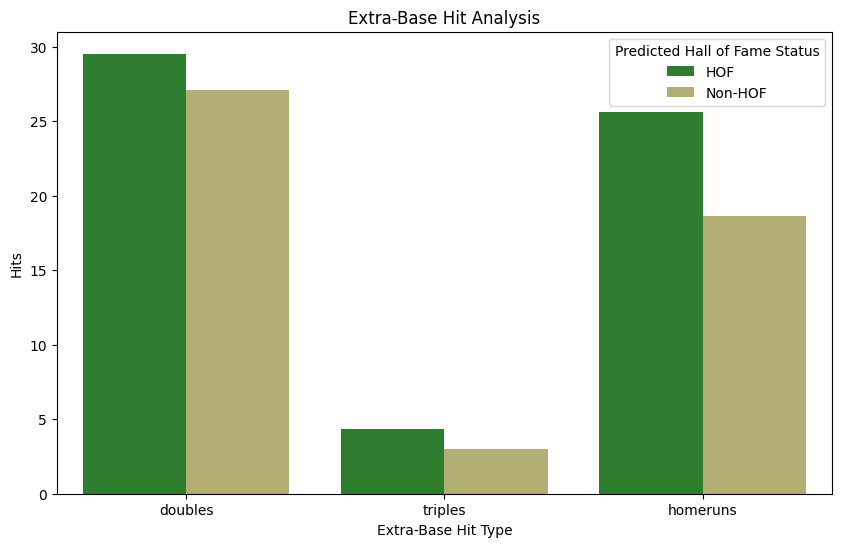

In [20]:
pivot_data = df.pivot_table(index='prediction_gb', values=['doubles', 'triples', 'homeruns'], aggfunc='mean')

pivot_data = pivot_data.reset_index()

melted_data = pivot_data.melt(id_vars='prediction_gb', var_name='Extra-Base Hit Type', value_name='Value')

order = ['doubles', 'triples', 'homeruns']

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=melted_data, x='Extra-Base Hit Type', y='Value', hue='prediction_gb', order=order, palette=p)

plt.title('Extra-Base Hit Analysis')
plt.xlabel('Extra-Base Hit Type')
plt.ylabel('Hits')
plt.legend(title='Predicted Hall of Fame Status')

plt.show()

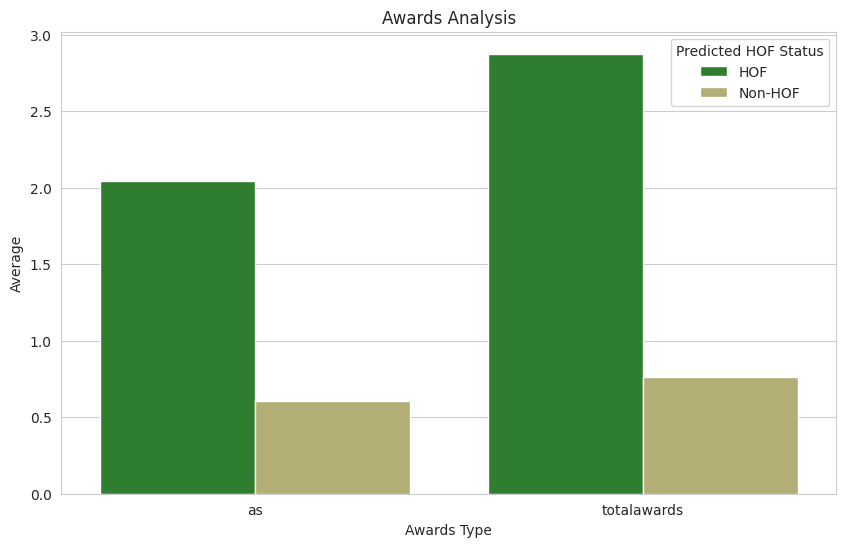

In [21]:
pivot_data = df.pivot_table(index='prediction_gb', values=['as', 'totalawards'], aggfunc='mean')

pivot_data = pivot_data.reset_index()

melted_data = pivot_data.melt(id_vars='prediction_gb', var_name='Honors', value_name='Value')

sns.set_style("whitegrid")

order = ['as', 'totalawards']

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=melted_data, x='Honors', y='Value', hue='prediction_gb', order=order, palette=p)

plt.title('Awards Analysis')
plt.xlabel('Awards Type')
plt.ylabel('Average')
plt.legend(title='Predicted HOF Status')

plt.show()

#predicted instead

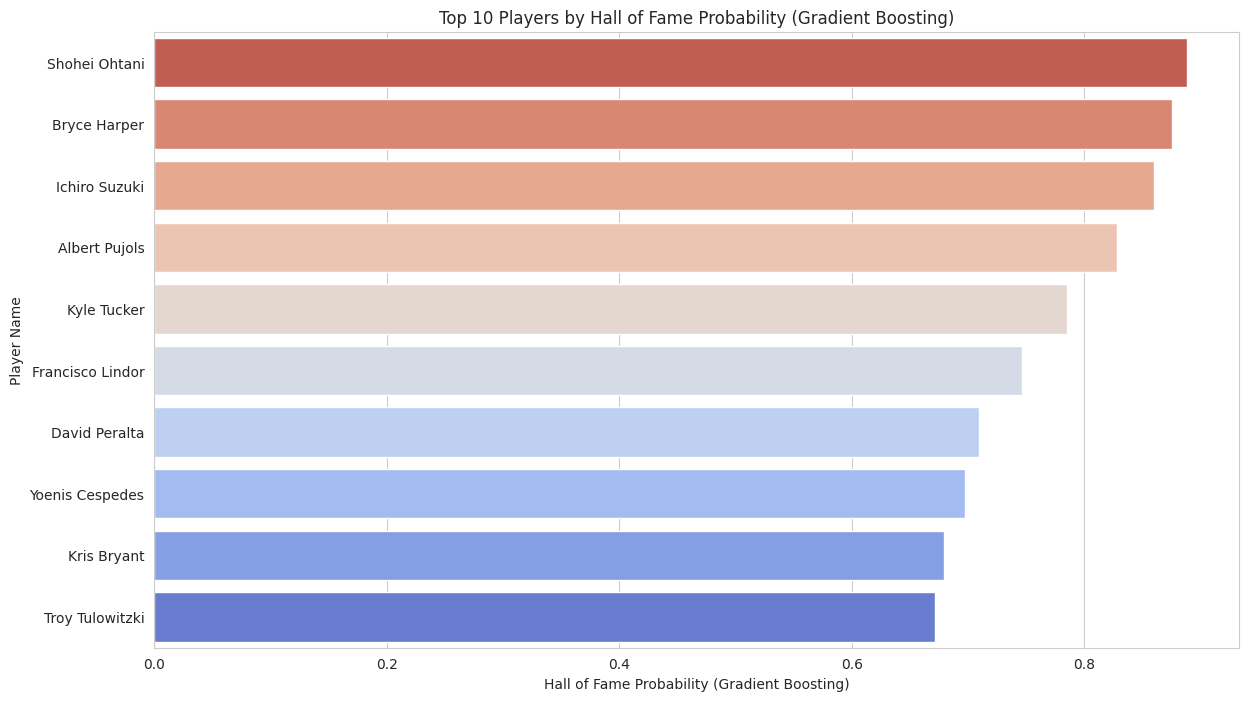

In [22]:
top_10_gb = merged_data.sort_values(by='HOF_prob_Gradient_Boosting', ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x='HOF_prob_Gradient_Boosting', y='playername', data=top_10_gb, palette='coolwarm_r')
plt.xlabel('Hall of Fame Probability (Gradient Boosting)')
plt.ylabel('Player Name') 
plt.title('Top 10 Players by Hall of Fame Probability (Gradient Boosting)')
plt.show()

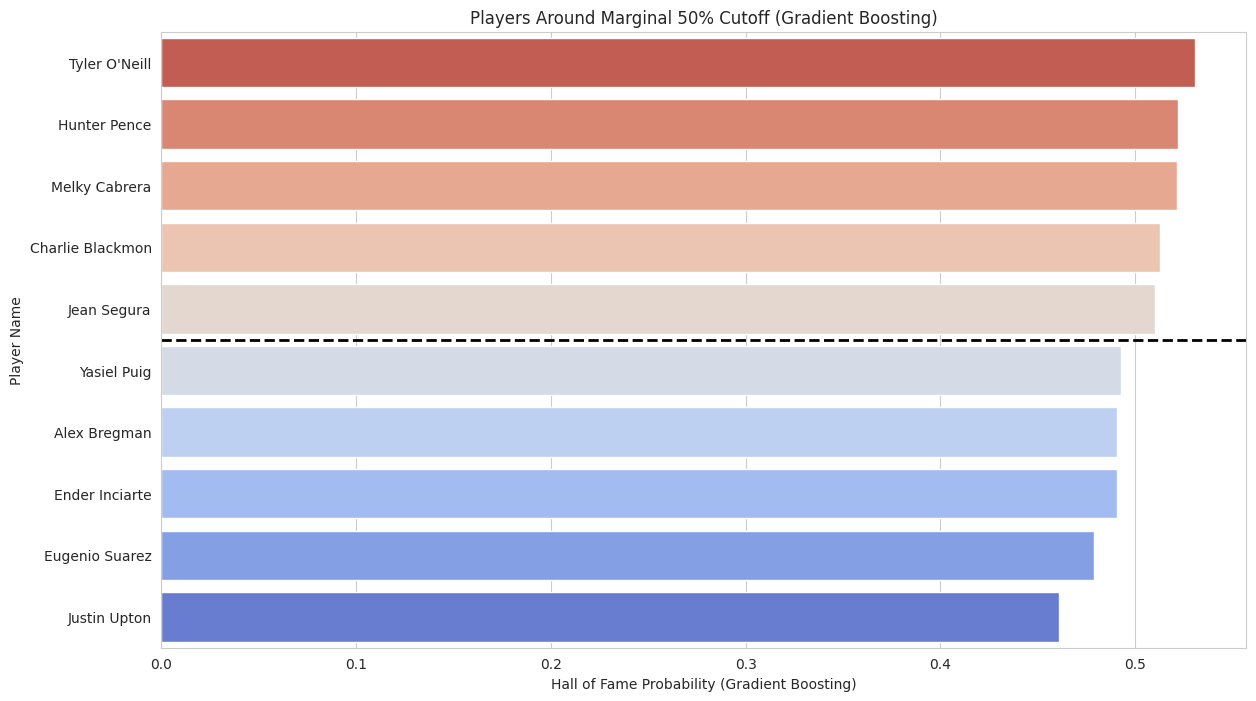

In [23]:
above_50 = merged_data[merged_data['HOF_prob_Gradient_Boosting'] >= 0.5]
top_above_50 = above_50.sort_values(by='HOF_prob_Gradient_Boosting', ascending=True).head(5)
top_above_50 = top_above_50.sort_values(by='HOF_prob_Gradient_Boosting', ascending=False).head(5)

below_50 = merged_data[merged_data['HOF_prob_Gradient_Boosting'] < 0.5]
bottom_below_50 = below_50.sort_values(by='HOF_prob_Gradient_Boosting', ascending=False).head(5)

top_bottom_players = pd.concat([top_above_50, bottom_below_50])

plt.figure(figsize=(14, 8))
sns.barplot(x='HOF_prob_Gradient_Boosting', y='playername', data=top_bottom_players, palette='coolwarm_r')
plt.xlabel('Hall of Fame Probability (Gradient Boosting)')
plt.ylabel('Player Name')
plt.title('Players Around Marginal 50% Cutoff (Gradient Boosting)')

plt.axhline(y=4.5, color='black', linewidth=2, linestyle='--')

plt.show()

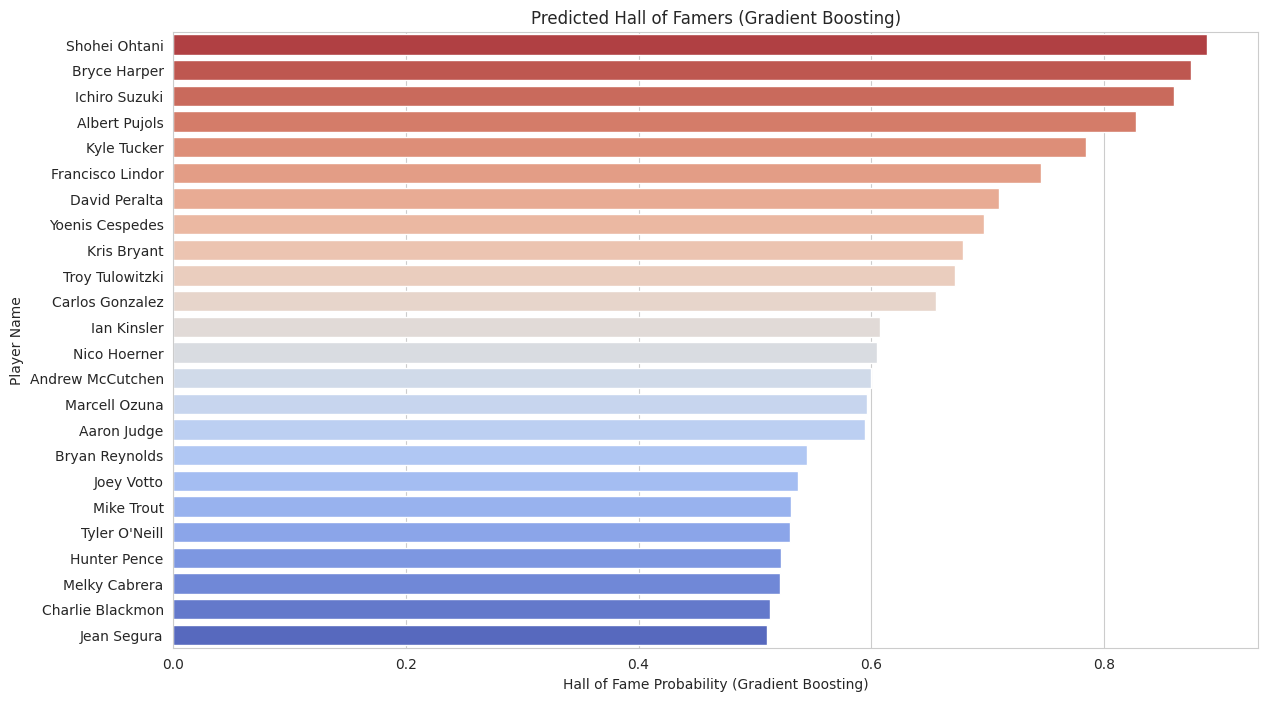

In [24]:
hofdf = df_hof.sort_values(by='HOF_prob_Gradient_Boosting', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x='HOF_prob_Gradient_Boosting', y='playername', data=hofdf, palette='coolwarm_r')
plt.xlabel('Hall of Fame Probability (Gradient Boosting)')
plt.ylabel('Player Name') 
plt.title('Predicted Hall of Famers (Gradient Boosting)')
plt.show()